## Define the Convolutional Neural Network

After you've looked at the data you're working with and, in this case, know the shapes of the images and of the keypoints, you are ready to define a convolutional neural network that can *learn* from this data.

In this notebook and in `models.py`, you will:
1. Define a CNN with images as input and keypoints as output
2. Construct the transformed FaceKeypointsDataset, just as before
3. Train the CNN on the training data, tracking loss
4. See how the trained model performs on test data
5. If necessary, modify the CNN structure and model hyperparameters, so that it performs *well* **\***

**\*** What does *well* mean?

"Well" means that the model's loss decreases during training **and**, when applied to test image data, the model produces keypoints that closely match the true keypoints of each face. And you'll see examples of this later in the notebook.

---


In [81]:
# import the usual resources
import matplotlib.pyplot as plt
import numpy as np

# watch for any changes in model.py, if it changes, re-load it automatically
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [103]:
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F

input_image_size = 224
depth = 1

# Instantiate the network
from models import Net

net = Net(input_image_size, depth)
print(net)

Net(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout1): Dropout2d(p=0.2)
  (conv2): Conv2d(32, 48, kernel_size=(5, 5), stride=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout2): Dropout2d(p=0.2)
  (conv3): Conv2d(48, 48, kernel_size=(3, 3), stride=(1, 1))
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout3): Dropout2d(p=0.2)
  (conv4): Conv2d(48, 64, kernel_size=(3, 3), stride=(1, 1))
  (pool4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=7744, out_features=4096, bias=True)
  (fc1_drop): Dropout(p=0.4)
  (fc2): Linear(in_features=4096, out_features=1028, bias=True)
  (output): Linear(in_features=1028, out_features=136, bias=True)
)


## Transform the dataset 

To prepare for training, create a transformed dataset of images and keypoints.

### TODO: Define a data transform

In PyTorch, a convolutional neural network expects a torch image of a consistent size as input. For efficient training, and so your model's loss does not blow up during training, it is also suggested that you normalize the input images and keypoints. The necessary transforms have been defined in `data_load.py` and you **do not** need to modify these; take a look at this file (you'll see the same transforms that were defined and applied in Notebook 1).

To define the data transform below, use a [composition](http://pytorch.org/tutorials/beginner/data_loading_tutorial.html#compose-transforms) of:
1. Rescaling and/or cropping the data, such that you are left with a square image (the suggested size is 224x224px)
2. Normalizing the images and keypoints; turning each RGB image into a grayscale image with a color range of [0, 1] and transforming the given keypoints into a range of [-1, 1]
3. Turning these images and keypoints into Tensors

These transformations have been defined in `data_load.py`, but it's up to you to call them and create a `data_transform` below. **This transform will be applied to the training data and, later, the test data**. It will change how you go about displaying these images and keypoints, but these steps are essential for efficient training.

As a note, should you want to perform data augmentation (which is optional in this project), and randomly rotate or shift these images, a square image size will be useful; rotating a 224x224 image by 90 degrees will result in the same shape of output.

In [104]:
def show_keypoints(image, key_pts):
    """Show image with keypoints"""
    plt.imshow(image)
    plt.scatter(key_pts[:, 0], key_pts[:, 1], s=20, marker='.', c='m')

In [116]:
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

# the dataset created in Notebook 1 is copied in the helper file `data_load.py`
from data_load import FacialKeypointsDataset

# the transforms defined in Notebook 1 are in the helper file `data_load.py`
from data_load import Normalize, ToTensor, RandomCrop, Rescale, RandomRescale


## TODO: define the data_transform using transforms.Compose([all tx's, . , .])
# order matters! i.e. rescaling should come before a smaller crop
data_transform = transforms.Compose([RandomRescale(input_image_size),
                                     RandomCrop(input_image_size),
                                     Normalize(),
                                     ToTensor()])

# testing that you've defined a transform
assert(data_transform is not None), 'Define a data_transform'

In [118]:
# create the transformed dataset
transformed_dataset = FacialKeypointsDataset(csv_file='data/training_frames_keypoints.csv',
                                             root_dir='data/training/',
                                             transform=data_transform)


print('Number of images: ', len(transformed_dataset))

# iterate through the transformed dataset and print some stats about the first few samples
for i in range(len(transformed_dataset)):
    sample = transformed_dataset[i]
    print(i, sample['image'].size(), sample['keypoints'].size())
    assert sample['image'].size() == (depth, input_image_size, input_image_size)

Number of images:  3452
Scale factor: 2.0979034885410104 
New image size: (402, 369, 3)
0 torch.Size([1, 224, 224]) torch.Size([68, 2])
Scale factor: 1.7335694311860095 
New image size: (339, 272, 3)
1 torch.Size([1, 224, 224]) torch.Size([68, 2])
Scale factor: 3.025198036732298 
New image size: (574, 514, 3)
2 torch.Size([1, 224, 224]) torch.Size([68, 2])
Scale factor: 1.4593151277538092 
New image size: (350, 310, 3)
3 torch.Size([1, 224, 224]) torch.Size([68, 2])
Scale factor: 1.9727183604491407 
New image size: (376, 362, 3)
4 torch.Size([1, 224, 224]) torch.Size([68, 2])
Scale factor: 1.9688215614073057 
New image size: (576, 450, 3)
5 torch.Size([1, 224, 224]) torch.Size([68, 2])
Scale factor: 5.7933578413439575 
New image size: (741, 585, 3)
6 torch.Size([1, 224, 224]) torch.Size([68, 2])
Scale factor: 3.4881438133502316 
New image size: (488, 624, 3)
7 torch.Size([1, 224, 224]) torch.Size([68, 2])
Scale factor: 1.7714310805471745 
New image size: (480, 373, 3)
8 torch.Size([1, 

New image size: (312, 351, 3)
98 torch.Size([1, 224, 224]) torch.Size([68, 2])
Scale factor: 1.351320584698841 
New image size: (306, 271, 3)
99 torch.Size([1, 224, 224]) torch.Size([68, 2])
Scale factor: 3.01265036084912 
New image size: (442, 352, 3)
100 torch.Size([1, 224, 224]) torch.Size([68, 2])
Scale factor: 3.391189127180286 
New image size: (583, 542, 3)
101 torch.Size([1, 224, 224]) torch.Size([68, 2])
Scale factor: 1.7823356005261206 
New image size: (427, 379, 3)
102 torch.Size([1, 224, 224]) torch.Size([68, 2])
Scale factor: 1.2502629123230045 
New image size: (301, 260, 3)
103 torch.Size([1, 224, 224]) torch.Size([68, 2])
Scale factor: 4.53136955712659 
New image size: (557, 448, 3)
104 torch.Size([1, 224, 224]) torch.Size([68, 2])
Scale factor: 4.09413342153411 
New image size: (552, 425, 3)
105 torch.Size([1, 224, 224]) torch.Size([68, 2])
Scale factor: 1.4261166203192341 
New image size: (268, 228, 3)
106 torch.Size([1, 224, 224]) torch.Size([68, 2])
Scale factor: 1.83

New image size: (477, 399, 3)
195 torch.Size([1, 224, 224]) torch.Size([68, 2])
Scale factor: 3.571071204022335 
New image size: (557, 449, 3)
196 torch.Size([1, 224, 224]) torch.Size([68, 2])
Scale factor: 2.554650584988691 
New image size: (533, 510, 3)
197 torch.Size([1, 224, 224]) torch.Size([68, 2])
Scale factor: 1.409443095892167 
New image size: (338, 335, 3)
198 torch.Size([1, 224, 224]) torch.Size([68, 2])
Scale factor: 1.954428512631558 
New image size: (320, 228, 3)
199 torch.Size([1, 224, 224]) torch.Size([68, 2])
Scale factor: 3.130671562869334 
New image size: (400, 313, 3)
200 torch.Size([1, 224, 224]) torch.Size([68, 2])
Scale factor: 2.2293708969952113 
New image size: (510, 499, 3)
201 torch.Size([1, 224, 224]) torch.Size([68, 2])
Scale factor: 2.6516036603341924 
New image size: (530, 408, 3)
202 torch.Size([1, 224, 224]) torch.Size([68, 2])
Scale factor: 3.199946903898943 
New image size: (665, 553, 3)
203 torch.Size([1, 224, 224]) torch.Size([68, 2])
Scale factor: 

New image size: (662, 580, 3)
289 torch.Size([1, 224, 224]) torch.Size([68, 2])
Scale factor: 2.979235053078398 
New image size: (381, 315, 3)
290 torch.Size([1, 224, 224]) torch.Size([68, 2])
Scale factor: 2.557674265254422 
New image size: (388, 705, 3)
291 torch.Size([1, 224, 224]) torch.Size([68, 2])
Scale factor: 1.5108759150831197 
New image size: (296, 504, 3)
292 torch.Size([1, 224, 224]) torch.Size([68, 2])
Scale factor: 1.1178630327769452 
New image size: (281, 225, 3)
293 torch.Size([1, 224, 224]) torch.Size([68, 2])
Scale factor: 1.7864805259633236 
New image size: (493, 332, 3)
294 torch.Size([1, 224, 224]) torch.Size([68, 2])
Scale factor: 1.8723206057856796 
New image size: (380, 323, 3)
295 torch.Size([1, 224, 224]) torch.Size([68, 2])
Scale factor: 1.8283546319745376 
New image size: (383, 329, 3)
296 torch.Size([1, 224, 224]) torch.Size([68, 2])
Scale factor: 1.9750748985375 
New image size: (470, 545, 3)
297 torch.Size([1, 224, 224]) torch.Size([68, 2])
Scale factor:

382 torch.Size([1, 224, 224]) torch.Size([68, 2])
Scale factor: 1.6627951606924412 
New image size: (337, 262, 3)
383 torch.Size([1, 224, 224]) torch.Size([68, 2])
Scale factor: 1.390073065568809 
New image size: (282, 307, 3)
384 torch.Size([1, 224, 224]) torch.Size([68, 2])
Scale factor: 5.5538026548631 
New image size: (638, 549, 3)
385 torch.Size([1, 224, 224]) torch.Size([68, 2])
Scale factor: 2.00573564247385 
New image size: (481, 489, 3)
386 torch.Size([1, 224, 224]) torch.Size([68, 2])
Scale factor: 2.6339736046150364 
New image size: (521, 463, 3)
387 torch.Size([1, 224, 224]) torch.Size([68, 2])
Scale factor: 2.4005548670356616 
New image size: (410, 396, 3)
388 torch.Size([1, 224, 224]) torch.Size([68, 2])
Scale factor: 1.797887245501248 
New image size: (336, 237, 3)
389 torch.Size([1, 224, 224]) torch.Size([68, 2])
Scale factor: 2.547804137569563 
New image size: (550, 489, 3)
390 torch.Size([1, 224, 224]) torch.Size([68, 2])
Scale factor: 2.8556571430996245 
New image si

473 torch.Size([1, 224, 224]) torch.Size([68, 2])
Scale factor: 2.1788496251428233 
New image size: (407, 405, 3)
474 torch.Size([1, 224, 224]) torch.Size([68, 2])
Scale factor: 3.356339371858314 
New image size: (483, 500, 3)
475 torch.Size([1, 224, 224]) torch.Size([68, 2])
Scale factor: 0.8455703267082758 
New image size: (233, 251, 3)
476 torch.Size([1, 224, 224]) torch.Size([68, 2])
Scale factor: 1.5770407118957652 
New image size: (291, 283, 3)
477 torch.Size([1, 224, 224]) torch.Size([68, 2])
Scale factor: 2.0066530284951933 
New image size: (367, 445, 3)
478 torch.Size([1, 224, 224]) torch.Size([68, 2])
Scale factor: 2.8535125791325315 
New image size: (547, 493, 3)
479 torch.Size([1, 224, 224]) torch.Size([68, 2])
Scale factor: 2.066025599459182 
New image size: (468, 392, 3)
480 torch.Size([1, 224, 224]) torch.Size([68, 2])
Scale factor: 3.645083308434024 
New image size: (393, 309, 3)
481 torch.Size([1, 224, 224]) torch.Size([68, 2])
Scale factor: 1.0041291002071921 
New ima

New image size: (398, 319, 3)
571 torch.Size([1, 224, 224]) torch.Size([68, 2])
Scale factor: 4.756410252471199 
New image size: (684, 494, 3)
572 torch.Size([1, 224, 224]) torch.Size([68, 2])
Scale factor: 1.5898664709265127 
New image size: (275, 303, 3)
573 torch.Size([1, 224, 224]) torch.Size([68, 2])
Scale factor: 3.0034676733805066 
New image size: (540, 567, 3)
574 torch.Size([1, 224, 224]) torch.Size([68, 2])
Scale factor: 2.541788669402439 
New image size: (477, 350, 3)
575 torch.Size([1, 224, 224]) torch.Size([68, 2])
Scale factor: 2.1972125317672937 
New image size: (435, 380, 3)
576 torch.Size([1, 224, 224]) torch.Size([68, 2])
Scale factor: 2.5653903047383166 
New image size: (307, 461, 3)
577 torch.Size([1, 224, 224]) torch.Size([68, 2])
Scale factor: 2.5324961776060335 
New image size: (607, 658, 3)
578 torch.Size([1, 224, 224]) torch.Size([68, 2])
Scale factor: 6.341110612800358 
New image size: (729, 697, 3)
579 torch.Size([1, 224, 224]) torch.Size([68, 2])
Scale facto

669 torch.Size([1, 224, 224]) torch.Size([68, 2])
Scale factor: 1.1592488220160622 
New image size: (340, 341, 3)
670 torch.Size([1, 224, 224]) torch.Size([68, 2])
Scale factor: 2.3388440892045264 
New image size: (261, 392, 3)
671 torch.Size([1, 224, 224]) torch.Size([68, 2])
Scale factor: 1.583948172875609 
New image size: (354, 294, 3)
672 torch.Size([1, 224, 224]) torch.Size([68, 2])
Scale factor: 2.5803099872333872 
New image size: (436, 371, 3)
673 torch.Size([1, 224, 224]) torch.Size([68, 2])
Scale factor: 1.1404597986667224 
New image size: (401, 380, 3)
674 torch.Size([1, 224, 224]) torch.Size([68, 2])
Scale factor: 1.6413703507060067 
New image size: (393, 443, 3)
675 torch.Size([1, 224, 224]) torch.Size([68, 2])
Scale factor: 1.1913144247967828 
New image size: (291, 282, 3)
676 torch.Size([1, 224, 224]) torch.Size([68, 2])
Scale factor: 2.3514112889997243 
New image size: (482, 409, 3)
677 torch.Size([1, 224, 224]) torch.Size([68, 2])
Scale factor: 2.4747317996760256 
New i

771 torch.Size([1, 224, 224]) torch.Size([68, 2])
Scale factor: 1.8221188654303369 
New image size: (340, 271, 3)
772 torch.Size([1, 224, 224]) torch.Size([68, 2])
Scale factor: 1.801090961221421 
New image size: (262, 255, 3)
773 torch.Size([1, 224, 224]) torch.Size([68, 2])
Scale factor: 4.895909289301835 
New image size: (660, 670, 3)
774 torch.Size([1, 224, 224]) torch.Size([68, 2])
Scale factor: 2.9309520155026227 
New image size: (559, 480, 3)
775 torch.Size([1, 224, 224]) torch.Size([68, 2])
Scale factor: 4.266631449189207 
New image size: (665, 490, 3)
776 torch.Size([1, 224, 224]) torch.Size([68, 2])
Scale factor: 1.5308296824351 
New image size: (356, 290, 3)
777 torch.Size([1, 224, 224]) torch.Size([68, 2])
Scale factor: 4.555381515503022 
New image size: (510, 409, 3)
778 torch.Size([1, 224, 224]) torch.Size([68, 2])
Scale factor: 1.8886184324227733 
New image size: (489, 311, 3)
779 torch.Size([1, 224, 224]) torch.Size([68, 2])
Scale factor: 0.9954222636518337 
New image s

New image size: (242, 225, 3)
868 torch.Size([1, 224, 224]) torch.Size([68, 2])
Scale factor: 1.0167957566402872 
New image size: (329, 249, 3)
869 torch.Size([1, 224, 224]) torch.Size([68, 2])
Scale factor: 2.7562368280140124 
New image size: (559, 537, 3)
870 torch.Size([1, 224, 224]) torch.Size([68, 2])
Scale factor: 1.8449138811162262 
New image size: (481, 584, 3)
871 torch.Size([1, 224, 224]) torch.Size([68, 2])
Scale factor: 1.042401488865539 
New image size: (279, 336, 3)
872 torch.Size([1, 224, 224]) torch.Size([68, 2])
Scale factor: 2.091373828919152 
New image size: (317, 267, 3)
873 torch.Size([1, 224, 224]) torch.Size([68, 2])
Scale factor: 5.523014549507154 
New image size: (574, 574, 3)
874 torch.Size([1, 224, 224]) torch.Size([68, 2])
Scale factor: 1.8175599131677087 
New image size: (372, 316, 3)
875 torch.Size([1, 224, 224]) torch.Size([68, 2])
Scale factor: 3.7249435017269072 
New image size: (502, 413, 3)
876 torch.Size([1, 224, 224]) torch.Size([68, 2])
Scale facto

New image size: (575, 429, 3)
969 torch.Size([1, 224, 224]) torch.Size([68, 2])
Scale factor: 1.9957283255155338 
New image size: (395, 379, 3)
970 torch.Size([1, 224, 224]) torch.Size([68, 2])
Scale factor: 2.3964457928829486 
New image size: (409, 428, 3)
971 torch.Size([1, 224, 224]) torch.Size([68, 2])
Scale factor: 1.5743037165819618 
New image size: (283, 297, 3)
972 torch.Size([1, 224, 224]) torch.Size([68, 2])
Scale factor: 1.013121768098902 
New image size: (364, 371, 3)
973 torch.Size([1, 224, 224]) torch.Size([68, 2])
Scale factor: 2.2603455068927625 
New image size: (594, 492, 3)
974 torch.Size([1, 224, 224]) torch.Size([68, 2])
Scale factor: 1.8972268913445458 
New image size: (295, 290, 3)
975 torch.Size([1, 224, 224]) torch.Size([68, 2])
Scale factor: 2.040691053855557 
New image size: (404, 402, 3)
976 torch.Size([1, 224, 224]) torch.Size([68, 2])
Scale factor: 3.447886877174412 
New image size: (593, 489, 3)
977 torch.Size([1, 224, 224]) torch.Size([68, 2])
Scale facto

New image size: (379, 332, 3)
1065 torch.Size([1, 224, 224]) torch.Size([68, 2])
Scale factor: 0.6343491783571021 
New image size: (228, 229, 3)
1066 torch.Size([1, 224, 224]) torch.Size([68, 2])
Scale factor: 1.7075585315847133 
New image size: (539, 496, 3)
1067 torch.Size([1, 224, 224]) torch.Size([68, 2])
Scale factor: 1.882324562271585 
New image size: (327, 359, 3)
1068 torch.Size([1, 224, 224]) torch.Size([68, 2])
Scale factor: 1.96979300447841 
New image size: (321, 299, 3)
1069 torch.Size([1, 224, 224]) torch.Size([68, 2])
Scale factor: 3.6460424407113576 
New image size: (681, 463, 3)
1070 torch.Size([1, 224, 224]) torch.Size([68, 2])
Scale factor: 1.1124810114772345 
New image size: (300, 329, 3)
1071 torch.Size([1, 224, 224]) torch.Size([68, 2])
Scale factor: 3.484492801579317 
New image size: (414, 344, 3)
1072 torch.Size([1, 224, 224]) torch.Size([68, 2])
Scale factor: 1.7573940680601554 
New image size: (267, 233, 3)
1073 torch.Size([1, 224, 224]) torch.Size([68, 2])
Sca

New image size: (401, 274, 3)
1162 torch.Size([1, 224, 224]) torch.Size([68, 2])
Scale factor: 4.640912883889415 
New image size: (649, 830, 3)
1163 torch.Size([1, 224, 224]) torch.Size([68, 2])
Scale factor: 2.229973341267912 
New image size: (327, 256, 3)
1164 torch.Size([1, 224, 224]) torch.Size([68, 2])
Scale factor: 4.589273726845876 
New image size: (587, 463, 3)
1165 torch.Size([1, 224, 224]) torch.Size([68, 2])
Scale factor: 1.135737292894347 
New image size: (316, 250, 3)
1166 torch.Size([1, 224, 224]) torch.Size([68, 2])
Scale factor: 1.990291979532914 
New image size: (302, 314, 3)
1167 torch.Size([1, 224, 224]) torch.Size([68, 2])
Scale factor: 1.6775358569169336 
New image size: (558, 478, 3)
1168 torch.Size([1, 224, 224]) torch.Size([68, 2])
Scale factor: 2.013166808455623 
New image size: (388, 372, 3)
1169 torch.Size([1, 224, 224]) torch.Size([68, 2])
Scale factor: 4.076713781008985 
New image size: (534, 432, 3)
1170 torch.Size([1, 224, 224]) torch.Size([68, 2])
Scale 

1262 torch.Size([1, 224, 224]) torch.Size([68, 2])
Scale factor: 1.0986759868554399 
New image size: (284, 227, 3)
1263 torch.Size([1, 224, 224]) torch.Size([68, 2])
Scale factor: 1.0569402320308403 
New image size: (303, 252, 3)
1264 torch.Size([1, 224, 224]) torch.Size([68, 2])
Scale factor: 4.849996616267165 
New image size: (518, 431, 3)
1265 torch.Size([1, 224, 224]) torch.Size([68, 2])
Scale factor: 1.9444244952518854 
New image size: (390, 338, 3)
1266 torch.Size([1, 224, 224]) torch.Size([68, 2])
Scale factor: 2.5386749491993474 
New image size: (487, 446, 3)
1267 torch.Size([1, 224, 224]) torch.Size([68, 2])
Scale factor: 2.5200127649002986 
New image size: (471, 483, 3)
1268 torch.Size([1, 224, 224]) torch.Size([68, 2])
Scale factor: 1.3171379568228965 
New image size: (247, 242, 3)
1269 torch.Size([1, 224, 224]) torch.Size([68, 2])
Scale factor: 1.8386655939329342 
New image size: (479, 582, 3)
1270 torch.Size([1, 224, 224]) torch.Size([68, 2])
Scale factor: 2.43773663138513

New image size: (295, 345, 3)
1361 torch.Size([1, 224, 224]) torch.Size([68, 2])
Scale factor: 2.962191112748723 
New image size: (305, 263, 3)
1362 torch.Size([1, 224, 224]) torch.Size([68, 2])
Scale factor: 1.5893000826241304 
New image size: (246, 249, 3)
1363 torch.Size([1, 224, 224]) torch.Size([68, 2])
Scale factor: 2.9389401353191156 
New image size: (432, 434, 3)
1364 torch.Size([1, 224, 224]) torch.Size([68, 2])
Scale factor: 1.5807320716145654 
New image size: (510, 410, 3)
1365 torch.Size([1, 224, 224]) torch.Size([68, 2])
Scale factor: 2.037555144684445 
New image size: (366, 323, 3)
1366 torch.Size([1, 224, 224]) torch.Size([68, 2])
Scale factor: 1.398413459692327 
New image size: (304, 295, 3)
1367 torch.Size([1, 224, 224]) torch.Size([68, 2])
Scale factor: 4.95584698838282 
New image size: (708, 678, 3)
1368 torch.Size([1, 224, 224]) torch.Size([68, 2])
Scale factor: 1.732470758834522 
New image size: (369, 393, 3)
1369 torch.Size([1, 224, 224]) torch.Size([68, 2])
Scale

1455 torch.Size([1, 224, 224]) torch.Size([68, 2])
Scale factor: 2.5166472376962794 
New image size: (470, 402, 3)
1456 torch.Size([1, 224, 224]) torch.Size([68, 2])
Scale factor: 6.259913918302074 
New image size: (719, 688, 3)
1457 torch.Size([1, 224, 224]) torch.Size([68, 2])
Scale factor: 3.0154452365063493 
New image size: (458, 367, 3)
1458 torch.Size([1, 224, 224]) torch.Size([68, 2])
Scale factor: 1.0020876734857662 
New image size: (360, 389, 3)
1459 torch.Size([1, 224, 224]) torch.Size([68, 2])
Scale factor: 3.646765880540501 
New image size: (481, 444, 3)
1460 torch.Size([1, 224, 224]) torch.Size([68, 2])
Scale factor: 3.333393232946837 
New image size: (490, 550, 3)
1461 torch.Size([1, 224, 224]) torch.Size([68, 2])
Scale factor: 5.185807953353605 
New image size: (622, 933, 3)
1462 torch.Size([1, 224, 224]) torch.Size([68, 2])
Scale factor: 1.5005706529934417 
New image size: (339, 349, 3)
1463 torch.Size([1, 224, 224]) torch.Size([68, 2])
Scale factor: 2.0105164247953597 

New image size: (506, 499, 3)
1551 torch.Size([1, 224, 224]) torch.Size([68, 2])
Scale factor: 2.1976434646887046 
New image size: (371, 380, 3)
1552 torch.Size([1, 224, 224]) torch.Size([68, 2])
Scale factor: 1.8949394463249232 
New image size: (570, 464, 3)
1553 torch.Size([1, 224, 224]) torch.Size([68, 2])
Scale factor: 3.041736799415339 
New image size: (404, 322, 3)
1554 torch.Size([1, 224, 224]) torch.Size([68, 2])
Scale factor: 2.9915703959922575 
New image size: (550, 460, 3)
1555 torch.Size([1, 224, 224]) torch.Size([68, 2])
Scale factor: 0.9746237979075463 
New image size: (323, 307, 3)
1556 torch.Size([1, 224, 224]) torch.Size([68, 2])
Scale factor: 1.8718186042306826 
New image size: (432, 357, 3)
1557 torch.Size([1, 224, 224]) torch.Size([68, 2])
Scale factor: 1.680757669614589 
New image size: (403, 327, 3)
1558 torch.Size([1, 224, 224]) torch.Size([68, 2])
Scale factor: 1.150337814284854 
New image size: (266, 273, 3)
1559 torch.Size([1, 224, 224]) torch.Size([68, 2])
Sc

New image size: (419, 354, 3)
1654 torch.Size([1, 224, 224]) torch.Size([68, 2])
Scale factor: 1.3286803591159848 
New image size: (425, 395, 3)
1655 torch.Size([1, 224, 224]) torch.Size([68, 2])
Scale factor: 1.1012306224772148 
New image size: (262, 303, 3)
1656 torch.Size([1, 224, 224]) torch.Size([68, 2])
Scale factor: 1.212679726412759 
New image size: (264, 230, 3)
1657 torch.Size([1, 224, 224]) torch.Size([68, 2])
Scale factor: 2.2686591841292336 
New image size: (451, 392, 3)
1658 torch.Size([1, 224, 224]) torch.Size([68, 2])
Scale factor: 2.723967932350244 
New image size: (503, 490, 3)
1659 torch.Size([1, 224, 224]) torch.Size([68, 2])
Scale factor: 3.1869429820686244 
New image size: (331, 331, 3)
1660 torch.Size([1, 224, 224]) torch.Size([68, 2])
Scale factor: 3.0991141346291373 
New image size: (536, 505, 3)
1661 torch.Size([1, 224, 224]) torch.Size([68, 2])
Scale factor: 1.5891791742090942 
New image size: (510, 489, 3)
1662 torch.Size([1, 224, 224]) torch.Size([68, 2])
S

Scale factor: 2.3921309068150265 
New image size: (389, 306, 3)
1741 torch.Size([1, 224, 224]) torch.Size([68, 2])
Scale factor: 1.5404546532640684 
New image size: (309, 294, 3)
1742 torch.Size([1, 224, 224]) torch.Size([68, 2])
Scale factor: 2.0394931311873914 
New image size: (469, 420, 3)
1743 torch.Size([1, 224, 224]) torch.Size([68, 2])
Scale factor: 2.5995733041910447 
New image size: (309, 246, 3)
1744 torch.Size([1, 224, 224]) torch.Size([68, 2])
Scale factor: 4.2742059813679125 
New image size: (512, 380, 3)
1745 torch.Size([1, 224, 224]) torch.Size([68, 2])
Scale factor: 2.7509998198894356 
New image size: (360, 343, 3)
1746 torch.Size([1, 224, 224]) torch.Size([68, 2])
Scale factor: 4.045048903198649 
New image size: (481, 400, 3)
1747 torch.Size([1, 224, 224]) torch.Size([68, 2])
Scale factor: 1.6390025841366453 
New image size: (376, 398, 3)
1748 torch.Size([1, 224, 224]) torch.Size([68, 2])
Scale factor: 3.7878832730186085 
New image size: (500, 545, 3)
1749 torch.Size([

New image size: (438, 418, 3)
1833 torch.Size([1, 224, 224]) torch.Size([68, 2])
Scale factor: 2.0558376450458242 
New image size: (386, 283, 3)
1834 torch.Size([1, 224, 224]) torch.Size([68, 2])
Scale factor: 2.173994320870234 
New image size: (586, 504, 3)
1835 torch.Size([1, 224, 224]) torch.Size([68, 2])
Scale factor: 0.8465772511646693 
New image size: (311, 264, 3)
1836 torch.Size([1, 224, 224]) torch.Size([68, 2])
Scale factor: 1.1972989441185318 
New image size: (431, 348, 3)
1837 torch.Size([1, 224, 224]) torch.Size([68, 2])
Scale factor: 1.1331871801086035 
New image size: (299, 282, 3)
1838 torch.Size([1, 224, 224]) torch.Size([68, 2])
Scale factor: 1.5394342299614867 
New image size: (330, 367, 3)
1839 torch.Size([1, 224, 224]) torch.Size([68, 2])
Scale factor: 3.426595734197786 
New image size: (507, 414, 3)
1840 torch.Size([1, 224, 224]) torch.Size([68, 2])
Scale factor: 0.9632700057042878 
New image size: (346, 338, 3)
1841 torch.Size([1, 224, 224]) torch.Size([68, 2])
S

New image size: (241, 228, 3)
1923 torch.Size([1, 224, 224]) torch.Size([68, 2])
Scale factor: 1.7724722873304581 
New image size: (246, 244, 3)
1924 torch.Size([1, 224, 224]) torch.Size([68, 2])
Scale factor: 2.7547419863368727 
New image size: (509, 539, 3)
1925 torch.Size([1, 224, 224]) torch.Size([68, 2])
Scale factor: 2.0293132447958078 
New image size: (389, 355, 3)
1926 torch.Size([1, 224, 224]) torch.Size([68, 2])
Scale factor: 4.4921754738397315 
New image size: (498, 498, 3)
1927 torch.Size([1, 224, 224]) torch.Size([68, 2])
Scale factor: 4.919185121305697 
New image size: (565, 565, 3)
1928 torch.Size([1, 224, 224]) torch.Size([68, 2])
Scale factor: 2.185005174170224 
New image size: (321, 360, 3)
1929 torch.Size([1, 224, 224]) torch.Size([68, 2])
Scale factor: 1.101094727762445 
New image size: (276, 226, 3)
1930 torch.Size([1, 224, 224]) torch.Size([68, 2])
Scale factor: 2.17645805735078 
New image size: (478, 450, 3)
1931 torch.Size([1, 224, 224]) torch.Size([68, 2])
Scal

New image size: (411, 430, 3)
2022 torch.Size([1, 224, 224]) torch.Size([68, 2])
Scale factor: 1.7816509165339645 
New image size: (290, 281, 3)
2023 torch.Size([1, 224, 224]) torch.Size([68, 2])
Scale factor: 5.250138530746735 
New image size: (567, 414, 3)
2024 torch.Size([1, 224, 224]) torch.Size([68, 2])
Scale factor: 2.5065984825461465 
New image size: (330, 330, 3)
2025 torch.Size([1, 224, 224]) torch.Size([68, 2])
Scale factor: 1.7415401368638392 
New image size: (311, 285, 3)
2026 torch.Size([1, 224, 224]) torch.Size([68, 2])
Scale factor: 2.3725014645408162 
New image size: (400, 410, 3)
2027 torch.Size([1, 224, 224]) torch.Size([68, 2])
Scale factor: 2.2886451330497803 
New image size: (370, 359, 3)
2028 torch.Size([1, 224, 224]) torch.Size([68, 2])
Scale factor: 5.725844691131249 
New image size: (612, 549, 3)
2029 torch.Size([1, 224, 224]) torch.Size([68, 2])
Scale factor: 3.0432804798271658 
New image size: (602, 502, 3)
2030 torch.Size([1, 224, 224]) torch.Size([68, 2])
S

New image size: (289, 412, 3)
2112 torch.Size([1, 224, 224]) torch.Size([68, 2])
Scale factor: 1.8527381278782127 
New image size: (489, 463, 3)
2113 torch.Size([1, 224, 224]) torch.Size([68, 2])
Scale factor: 1.75185762724124 
New image size: (488, 415, 3)
2114 torch.Size([1, 224, 224]) torch.Size([68, 2])
Scale factor: 2.904610927700112 
New image size: (537, 464, 3)
2115 torch.Size([1, 224, 224]) torch.Size([68, 2])
Scale factor: 2.1728305155303023 
New image size: (497, 473, 3)
2116 torch.Size([1, 224, 224]) torch.Size([68, 2])
Scale factor: 2.0485409862141255 
New image size: (581, 487, 3)
2117 torch.Size([1, 224, 224]) torch.Size([68, 2])
Scale factor: 2.199536260088733 
New image size: (499, 444, 3)
2118 torch.Size([1, 224, 224]) torch.Size([68, 2])
Scale factor: 1.210552696800402 
New image size: (326, 377, 3)
2119 torch.Size([1, 224, 224]) torch.Size([68, 2])
Scale factor: 3.182848150687929 
New image size: (448, 366, 3)
2120 torch.Size([1, 224, 224]) torch.Size([68, 2])
Scale

New image size: (258, 289, 3)
2212 torch.Size([1, 224, 224]) torch.Size([68, 2])
Scale factor: 3.630526395000917 
New image size: (479, 522, 3)
2213 torch.Size([1, 224, 224]) torch.Size([68, 2])
Scale factor: 1.2315951513981414 
New image size: (315, 266, 3)
2214 torch.Size([1, 224, 224]) torch.Size([68, 2])
Scale factor: 1.2232956411761449 
New image size: (472, 411, 3)
2215 torch.Size([1, 224, 224]) torch.Size([68, 2])
Scale factor: 1.6260313849918948 
New image size: (364, 276, 3)
2216 torch.Size([1, 224, 224]) torch.Size([68, 2])
Scale factor: 3.5303847272514814 
New image size: (727, 970, 3)
2217 torch.Size([1, 224, 224]) torch.Size([68, 2])
Scale factor: 1.7230115372278183 
New image size: (296, 272, 3)
2218 torch.Size([1, 224, 224]) torch.Size([68, 2])
Scale factor: 3.464786016443213 
New image size: (526, 547, 3)
2219 torch.Size([1, 224, 224]) torch.Size([68, 2])
Scale factor: 1.7099462962588092 
New image size: (299, 295, 3)
2220 torch.Size([1, 224, 224]) torch.Size([68, 2])
S

Scale factor: 3.094852011408029 
New image size: (482, 473, 3)
2310 torch.Size([1, 224, 224]) torch.Size([68, 2])
Scale factor: 1.8540293163479709 
New image size: (483, 439, 3)
2311 torch.Size([1, 224, 224]) torch.Size([68, 2])
Scale factor: 3.350620894941696 
New image size: (536, 475, 3)
2312 torch.Size([1, 224, 224]) torch.Size([68, 2])
Scale factor: 1.1663975583475459 
New image size: (344, 276, 3)
2313 torch.Size([1, 224, 224]) torch.Size([68, 2])
Scale factor: 2.5336027954132003 
New image size: (326, 344, 3)
2314 torch.Size([1, 224, 224]) torch.Size([68, 2])
Scale factor: 1.6973790657879284 
New image size: (319, 268, 3)
2315 torch.Size([1, 224, 224]) torch.Size([68, 2])
Scale factor: 1.1282504349917375 
New image size: (332, 274, 3)
2316 torch.Size([1, 224, 224]) torch.Size([68, 2])
Scale factor: 1.4106978324238244 
New image size: (290, 253, 3)
2317 torch.Size([1, 224, 224]) torch.Size([68, 2])
Scale factor: 2.396141054959071 
New image size: (412, 416, 3)
2318 torch.Size([1,

New image size: (254, 225, 3)
2412 torch.Size([1, 224, 224]) torch.Size([68, 2])
Scale factor: 1.984795786583423 
New image size: (420, 396, 3)
2413 torch.Size([1, 224, 224]) torch.Size([68, 2])
Scale factor: 1.7450819382388967 
New image size: (418, 492, 3)
2414 torch.Size([1, 224, 224]) torch.Size([68, 2])
Scale factor: 1.1722613281779166 
New image size: (243, 303, 3)
2415 torch.Size([1, 224, 224]) torch.Size([68, 2])
Scale factor: 2.8655576983675624 
New image size: (538, 363, 3)
2416 torch.Size([1, 224, 224]) torch.Size([68, 2])
Scale factor: 2.694256917118043 
New image size: (334, 269, 3)
2417 torch.Size([1, 224, 224]) torch.Size([68, 2])
Scale factor: 1.7919658850884237 
New image size: (480, 428, 3)
2418 torch.Size([1, 224, 224]) torch.Size([68, 2])
Scale factor: 1.7377432452184882 
New image size: (396, 389, 3)
2419 torch.Size([1, 224, 224]) torch.Size([68, 2])
Scale factor: 2.373654001135349 
New image size: (287, 261, 3)
2420 torch.Size([1, 224, 224]) torch.Size([68, 2])
Sc

New image size: (263, 247, 3)
2513 torch.Size([1, 224, 224]) torch.Size([68, 2])
Scale factor: 3.7934205001632626 
New image size: (379, 280, 3)
2514 torch.Size([1, 224, 224]) torch.Size([68, 2])
Scale factor: 1.5913030292041095 
New image size: (381, 509, 3)
2515 torch.Size([1, 224, 224]) torch.Size([68, 2])
Scale factor: 1.9972253339062285 
New image size: (421, 339, 3)
2516 torch.Size([1, 224, 224]) torch.Size([68, 2])
Scale factor: 1.1484847070042994 
New image size: (365, 345, 3)
2517 torch.Size([1, 224, 224]) torch.Size([68, 2])
Scale factor: 3.254223519757415 
New image size: (390, 325, 3)
2518 torch.Size([1, 224, 224]) torch.Size([68, 2])
Scale factor: 1.684257140026578 
New image size: (308, 373, 3)
2519 torch.Size([1, 224, 224]) torch.Size([68, 2])
Scale factor: 1.8257143336344732 
New image size: (485, 496, 3)
2520 torch.Size([1, 224, 224]) torch.Size([68, 2])
Scale factor: 1.7597108192348383 
New image size: (480, 411, 3)
2521 torch.Size([1, 224, 224]) torch.Size([68, 2])
S

New image size: (569, 512, 3)
2613 torch.Size([1, 224, 224]) torch.Size([68, 2])
Scale factor: 1.5404781794702813 
New image size: (289, 243, 3)
2614 torch.Size([1, 224, 224]) torch.Size([68, 2])
Scale factor: 2.178636482836863 
New image size: (599, 470, 3)
2615 torch.Size([1, 224, 224]) torch.Size([68, 2])
Scale factor: 2.0213485265748363 
New image size: (430, 373, 3)
2616 torch.Size([1, 224, 224]) torch.Size([68, 2])
Scale factor: 3.492742303922716 
New image size: (523, 436, 3)
2617 torch.Size([1, 224, 224]) torch.Size([68, 2])
Scale factor: 3.4074702143579385 
New image size: (514, 429, 3)
2618 torch.Size([1, 224, 224]) torch.Size([68, 2])
Scale factor: 5.510278914460654 
New image size: (595, 705, 3)
2619 torch.Size([1, 224, 224]) torch.Size([68, 2])
Scale factor: 0.8914288112926452 
New image size: (338, 336, 3)
2620 torch.Size([1, 224, 224]) torch.Size([68, 2])
Scale factor: 4.2365112565397 
New image size: (440, 377, 3)
2621 torch.Size([1, 224, 224]) torch.Size([68, 2])
Scale

New image size: (268, 238, 3)
2713 torch.Size([1, 224, 224]) torch.Size([68, 2])
Scale factor: 2.3206977404447175 
New image size: (287, 232, 3)
2714 torch.Size([1, 224, 224]) torch.Size([68, 2])
Scale factor: 1.3606019160227267 
New image size: (326, 337, 3)
2715 torch.Size([1, 224, 224]) torch.Size([68, 2])
Scale factor: 2.6324128527708854 
New image size: (336, 379, 3)
2716 torch.Size([1, 224, 224]) torch.Size([68, 2])
Scale factor: 1.8664546340149832 
New image size: (386, 334, 3)
2717 torch.Size([1, 224, 224]) torch.Size([68, 2])
Scale factor: 3.5044188991697807 
New image size: (557, 371, 3)
2718 torch.Size([1, 224, 224]) torch.Size([68, 2])
Scale factor: 5.06177612492699 
New image size: (546, 430, 3)
2719 torch.Size([1, 224, 224]) torch.Size([68, 2])
Scale factor: 2.3536090861426437 
New image size: (308, 233, 3)
2720 torch.Size([1, 224, 224]) torch.Size([68, 2])
Scale factor: 2.145595575655852 
New image size: (532, 439, 3)
2721 torch.Size([1, 224, 224]) torch.Size([68, 2])
Sc

New image size: (359, 356, 3)
2807 torch.Size([1, 224, 224]) torch.Size([68, 2])
Scale factor: 3.232796462220207 
New image size: (471, 375, 3)
2808 torch.Size([1, 224, 224]) torch.Size([68, 2])
Scale factor: 1.9143519040508172 
New image size: (394, 526, 3)
2809 torch.Size([1, 224, 224]) torch.Size([68, 2])
Scale factor: 1.6969939097300148 
New image size: (254, 224, 3)
2810 torch.Size([1, 224, 224]) torch.Size([68, 2])
Scale factor: 2.573483121699434 
New image size: (378, 295, 3)
2811 torch.Size([1, 224, 224]) torch.Size([68, 2])
Scale factor: 1.0080802392362367 
New image size: (241, 263, 3)
2812 torch.Size([1, 224, 224]) torch.Size([68, 2])
Scale factor: 4.147183358396186 
New image size: (510, 373, 3)
2813 torch.Size([1, 224, 224]) torch.Size([68, 2])
Scale factor: 1.3609948254605466 
New image size: (367, 454, 3)
2814 torch.Size([1, 224, 224]) torch.Size([68, 2])
Scale factor: 1.7639702103999806 
New image size: (508, 432, 3)
2815 torch.Size([1, 224, 224]) torch.Size([68, 2])
Sc

New image size: (260, 286, 3)
2903 torch.Size([1, 224, 224]) torch.Size([68, 2])
Scale factor: 1.8174383487746248 
New image size: (323, 327, 3)
2904 torch.Size([1, 224, 224]) torch.Size([68, 2])
Scale factor: 2.123011560191702 
New image size: (430, 392, 3)
2905 torch.Size([1, 224, 224]) torch.Size([68, 2])
Scale factor: 1.0866542879890764 
New image size: (297, 312, 3)
2906 torch.Size([1, 224, 224]) torch.Size([68, 2])
Scale factor: 1.5408608697191162 
New image size: (443, 365, 3)
2907 torch.Size([1, 224, 224]) torch.Size([68, 2])
Scale factor: 3.929935845928222 
New image size: (672, 475, 3)
2908 torch.Size([1, 224, 224]) torch.Size([68, 2])
Scale factor: 2.259972792175712 
New image size: (451, 345, 3)
2909 torch.Size([1, 224, 224]) torch.Size([68, 2])
Scale factor: 1.5244632555355344 
New image size: (321, 259, 3)
2910 torch.Size([1, 224, 224]) torch.Size([68, 2])
Scale factor: 0.9972257517832372 
New image size: (239, 274, 3)
2911 torch.Size([1, 224, 224]) torch.Size([68, 2])
Sc

New image size: (354, 337, 3)
2999 torch.Size([1, 224, 224]) torch.Size([68, 2])
Scale factor: 3.2964188819414497 
New image size: (616, 613, 3)
3000 torch.Size([1, 224, 224]) torch.Size([68, 2])
Scale factor: 2.3584387035985874 
New image size: (509, 436, 3)
3001 torch.Size([1, 224, 224]) torch.Size([68, 2])
Scale factor: 1.1978896605504863 
New image size: (368, 342, 3)
3002 torch.Size([1, 224, 224]) torch.Size([68, 2])
Scale factor: 1.8044282663256452 
New image size: (433, 333, 3)
3003 torch.Size([1, 224, 224]) torch.Size([68, 2])
Scale factor: 2.334632872212218 
New image size: (350, 331, 3)
3004 torch.Size([1, 224, 224]) torch.Size([68, 2])
Scale factor: 2.7499422392461144 
New image size: (338, 332, 3)
3005 torch.Size([1, 224, 224]) torch.Size([68, 2])
Scale factor: 1.105170374495976 
New image size: (257, 227, 3)
3006 torch.Size([1, 224, 224]) torch.Size([68, 2])
Scale factor: 1.2309777596510532 
New image size: (317, 299, 3)
3007 torch.Size([1, 224, 224]) torch.Size([68, 2])
S

Scale factor: 1.413937379573268 
New image size: (298, 301, 3)
3096 torch.Size([1, 224, 224]) torch.Size([68, 2])
Scale factor: 1.1705905187206112 
New image size: (374, 321, 3)
3097 torch.Size([1, 224, 224]) torch.Size([68, 2])
Scale factor: 2.773038389106153 
New image size: (537, 488, 3)
3098 torch.Size([1, 224, 224]) torch.Size([68, 2])
Scale factor: 3.0849070044470803 
New image size: (370, 308, 3)
3099 torch.Size([1, 224, 224]) torch.Size([68, 2])
Scale factor: 3.244898343207896 
New image size: (538, 467, 3)
3100 torch.Size([1, 224, 224]) torch.Size([68, 2])
Scale factor: 1.0656172287472647 
New image size: (255, 255, 3)
3101 torch.Size([1, 224, 224]) torch.Size([68, 2])
Scale factor: 0.9464916809748954 
New image size: (269, 230, 3)
3102 torch.Size([1, 224, 224]) torch.Size([68, 2])
Scale factor: 1.151836976804097 
New image size: (320, 276, 3)
3103 torch.Size([1, 224, 224]) torch.Size([68, 2])
Scale factor: 2.344188781288162 
New image size: (370, 300, 3)
3104 torch.Size([1, 2

Scale factor: 2.8545936430910666 
New image size: (499, 453, 3)
3191 torch.Size([1, 224, 224]) torch.Size([68, 2])
Scale factor: 2.331967306681238 
New image size: (585, 545, 3)
3192 torch.Size([1, 224, 224]) torch.Size([68, 2])
Scale factor: 1.2377751455645418 
New image size: (253, 253, 3)
3193 torch.Size([1, 224, 224]) torch.Size([68, 2])
Scale factor: 2.840692469530363 
New image size: (588, 491, 3)
3194 torch.Size([1, 224, 224]) torch.Size([68, 2])
Scale factor: 1.6311783549334002 
New image size: (463, 355, 3)
3195 torch.Size([1, 224, 224]) torch.Size([68, 2])
Scale factor: 1.0918376269133214 
New image size: (255, 226, 3)
3196 torch.Size([1, 224, 224]) torch.Size([68, 2])
Scale factor: 1.7765074014513984 
New image size: (417, 319, 3)
3197 torch.Size([1, 224, 224]) torch.Size([68, 2])
Scale factor: 1.6946746441863323 
New image size: (306, 271, 3)
3198 torch.Size([1, 224, 224]) torch.Size([68, 2])
Scale factor: 2.436102783359668 
New image size: (538, 552, 3)
3199 torch.Size([1,

New image size: (462, 433, 3)
3284 torch.Size([1, 224, 224]) torch.Size([68, 2])
Scale factor: 2.880909093547186 
New image size: (466, 362, 3)
3285 torch.Size([1, 224, 224]) torch.Size([68, 2])
Scale factor: 2.6685252706566627 
New image size: (381, 293, 3)
3286 torch.Size([1, 224, 224]) torch.Size([68, 2])
Scale factor: 1.4234612349702733 
New image size: (317, 331, 3)
3287 torch.Size([1, 224, 224]) torch.Size([68, 2])
Scale factor: 1.0890017445510196 
New image size: (348, 364, 3)
3288 torch.Size([1, 224, 224]) torch.Size([68, 2])
Scale factor: 2.009424833869955 
New image size: (434, 385, 3)
3289 torch.Size([1, 224, 224]) torch.Size([68, 2])
Scale factor: 2.9548051778464135 
New image size: (596, 558, 3)
3290 torch.Size([1, 224, 224]) torch.Size([68, 2])
Scale factor: 3.046469727903021 
New image size: (594, 575, 3)
3291 torch.Size([1, 224, 224]) torch.Size([68, 2])
Scale factor: 2.39523451027475 
New image size: (457, 378, 3)
3292 torch.Size([1, 224, 224]) torch.Size([68, 2])
Scal

Scale factor: 3.475994456747096 
New image size: (552, 497, 3)
3382 torch.Size([1, 224, 224]) torch.Size([68, 2])
Scale factor: 2.0506534661408917 
New image size: (365, 379, 3)
3383 torch.Size([1, 224, 224]) torch.Size([68, 2])
Scale factor: 1.4705032078006384 
New image size: (352, 388, 3)
3384 torch.Size([1, 224, 224]) torch.Size([68, 2])
Scale factor: 1.6727388181051817 
New image size: (388, 326, 3)
3385 torch.Size([1, 224, 224]) torch.Size([68, 2])
Scale factor: 2.9267361861289 
New image size: (427, 415, 3)
3386 torch.Size([1, 224, 224]) torch.Size([68, 2])
Scale factor: 1.4751209717436264 
New image size: (418, 351, 3)
3387 torch.Size([1, 224, 224]) torch.Size([68, 2])
Scale factor: 2.055156562812252 
New image size: (493, 499, 3)
3388 torch.Size([1, 224, 224]) torch.Size([68, 2])
Scale factor: 1.6747390925840417 
New image size: (272, 264, 3)
3389 torch.Size([1, 224, 224]) torch.Size([68, 2])
Scale factor: 1.5805536573016394 
New image size: (391, 342, 3)
3390 torch.Size([1, 2

## Batching and loading data

Next, having defined the transformed dataset, we can use PyTorch's DataLoader class to load the training data in batches of whatever size as well as to shuffle the data for training the model. You can read more about the parameters of the DataLoader, in [this documentation](http://pytorch.org/docs/master/data.html).

#### Batch size
Decide on a good batch size for training your model. Try both small and large batch sizes and note how the loss decreases as the model trains.

**Note for Windows users**: Please change the `num_workers` to 0 or you may face some issues with your DataLoader failing.

In [120]:
# load training data in batches
batch_size = 8

train_loader = DataLoader(transformed_dataset, 
                          batch_size=batch_size,
                          shuffle=True, 
                          num_workers=2)


## Before training

Take a look at how this model performs before it trains. You should see that the keypoints it predicts start off in one spot and don't match the keypoints on a face at all! It's interesting to visualize this behavior so that you can compare it to the model after training and see how the model has improved.

#### Load in the test dataset

The test dataset is one that this model has *not* seen before, meaning it has not trained with these images. We'll load in this test data and before and after training, see how your model performs on this set!

To visualize this test data, we have to go through some un-transformation steps to turn our images into python images from tensors and to turn our keypoints back into a recognizable range. 

In [121]:
# load in the test data, using the dataset class
# AND apply the data_transform you defined above

# create the test dataset
test_dataset = FacialKeypointsDataset(csv_file='data/test_frames_keypoints.csv',
                                             root_dir='data/test/',
                                             transform=data_transform)



In [122]:
# load test data in batches
test_loader = DataLoader(test_dataset, 
                          batch_size=batch_size,
                          shuffle=True, 
                          num_workers=0)

## Apply the model on a test sample

To test the model on a test sample of data, you have to follow these steps:
1. Extract the image and ground truth keypoints from a sample
2. Wrap the image in a Variable, so that the net can process it as input and track how it changes as the image moves through the network.
3. Make sure the image is a FloatTensor, which the model expects.
4. Forward pass the image through the net to get the predicted, output keypoints.

This function test how the network performs on the first batch of test data. It returns the images, the transformed images, the predicted keypoints (produced by the model), and the ground truth keypoints.

In [123]:
# test the model on a batch of test images

def net_sample_output():
    
    # iterate through the test dataset
    for i, sample in enumerate(test_loader):
        
        # get sample data: images and ground truth keypoints
        images = sample['image']
        key_pts = sample['keypoints']
        
        # wrap images in a torch Variable
        # key_pts do not need to be wrapped until they are used for training
        images = Variable(images)

        # convert images to FloatTensors
        images = images.type(torch.FloatTensor)

        # forward pass to get net output
        output_pts = net(images)
        
        # reshape to batch_size x 68 x 2 pts
        output_pts = output_pts.view(output_pts.size()[0], 68, -1)
        
        # break after first image is tested
        if i == 0:
            return images, output_pts, key_pts
            

#### Debugging tips

If you get a size or dimension error here, make sure that your network outputs the expected number of keypoints! Or if you get a Tensor type error, look into changing the above code that casts the data into float types: `images = images.type(torch.FloatTensor)`.

In [124]:
# call the above function
# returns: test images, test predicted keypoints, test ground truth keypoints
test_images, test_outputs, gt_pts = net_sample_output()

# print out the dimensions of the data to see if they make sense
print(test_images.data.size())
print(test_outputs.data.size())
print(gt_pts.size())

torch.Size([8, 1, 224, 224])
torch.Size([8, 68, 2])
torch.Size([8, 68, 2])


## Visualize the predicted keypoints

Once we've had the model produce some predicted output keypoints, we can visualize these points in a way that's similar to how we've displayed this data before, only this time, we have to "un-transform" the image/keypoint data to display it.

Note that I've defined a *new* function, `show_all_keypoints` that displays a grayscale image, its predicted keypoints and its ground truth keypoints (if provided).

In [125]:
def show_all_keypoints(image, predicted_key_pts, gt_pts=None):
    """Show image with predicted keypoints"""
    # image is grayscale
    plt.imshow(image, cmap='gray')
    plt.scatter(predicted_key_pts[:, 0], predicted_key_pts[:, 1], s=20, marker='.', c='y')
    # plot ground truth points as green pts
    if gt_pts is not None:
        plt.scatter(gt_pts[:, 0], gt_pts[:, 1], s=20, marker='.', c='g')


#### Un-transformation

Next, you'll see a helper function. `visualize_output` that takes in a batch of images, predicted keypoints, and ground truth keypoints and displays a set of those images and their true/predicted keypoints.

This function's main role is to take batches of image and keypoint data (the input and output of your CNN), and transform them into numpy images and un-normalized keypoints (x, y) for normal display. The un-transformation process turns keypoints and images into numpy arrays from Tensors *and* it undoes the keypoint normalization done in the Normalize() transform; it's assumed that you applied these transformations when you loaded your test data.

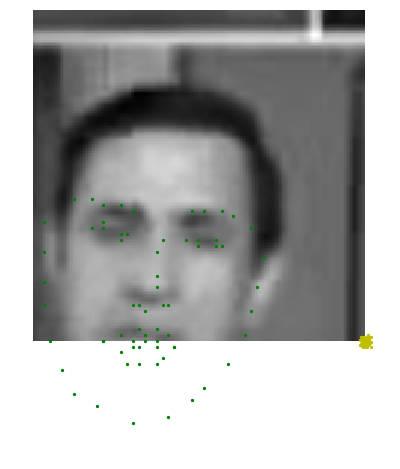

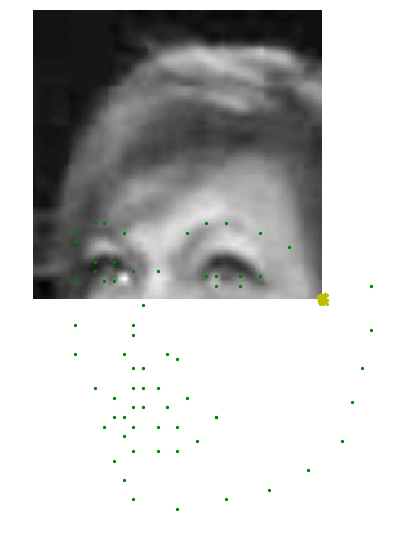

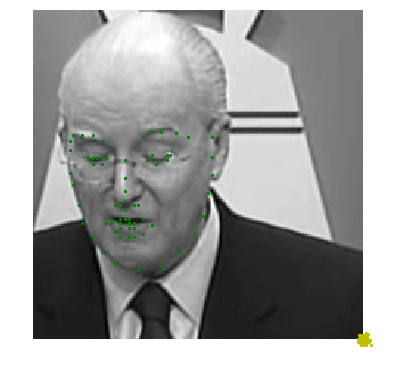

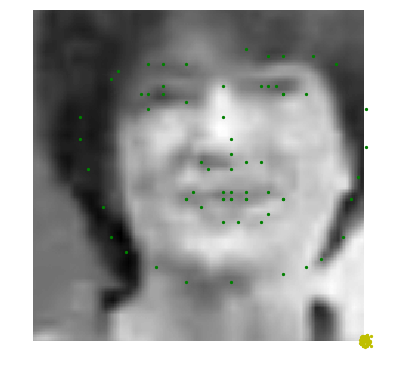

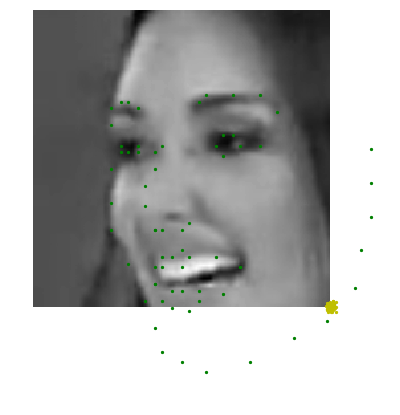

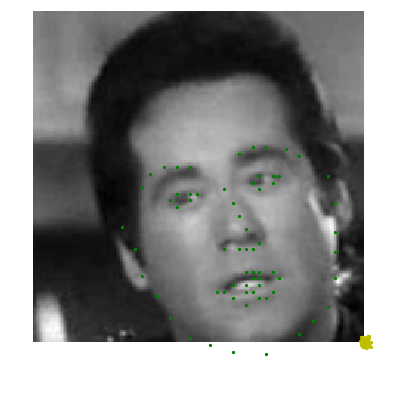

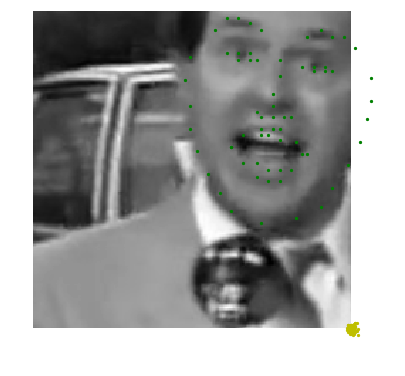

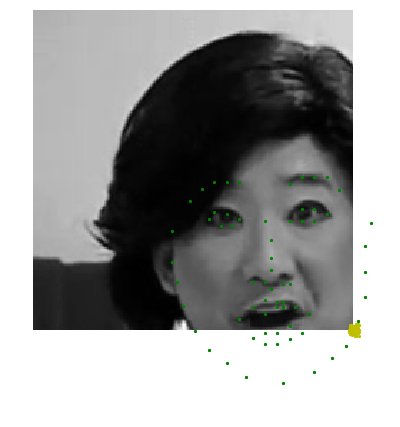

In [126]:
# visualize the output
# by default this shows a batch of 10 images
def visualize_output(test_images, test_outputs, batch_size, gt_pts=None):

    for i in range(batch_size):
        plt.figure(figsize=(60,10))
        ax = plt.subplot(1, batch_size, i+1)

        # un-transform the image data
        image = test_images[i].data   # get the image from it's Variable wrapper
        image = image.numpy()   # convert to numpy array from a Tensor
        image = np.transpose(image, (1, 2, 0))   # transpose to go from torch to numpy image

        # un-transform the predicted key_pts data
        predicted_key_pts = test_outputs[i].data
        predicted_key_pts = predicted_key_pts.numpy()
        # undo normalization of keypoints  

        predicted_key_pts = predicted_key_pts*(image.shape[0]/2)+(image.shape[0])

        # plot ground truth points for comparison, if they exist
        ground_truth_pts = None
        if gt_pts is not None:
            ground_truth_pts = gt_pts[i]  
            ground_truth_pts = (ground_truth_pts*(image.shape[0]/2))+(image.shape[0])
        
        # call show_all_keypoints
        show_all_keypoints(np.squeeze(image), predicted_key_pts, ground_truth_pts)
            
        plt.axis('off')

    plt.show()
    
# call it
test_images, test_outputs, gt_pts = net_sample_output()
visualize_output(test_images, test_outputs, batch_size, gt_pts)

## Training

#### Loss function
Training a network to predict keypoints is different than training a network to predict a class; instead of outputting a distribution of classes and using cross entropy loss, you may want to choose a loss function that is suited for regression, which directly compares a predicted value and target value. Read about the various kinds of loss functions (like MSE or L1/SmoothL1 loss) in [this documentation](http://pytorch.org/docs/master/_modules/torch/nn/modules/loss.html).

### TODO: Define the loss and optimization

Next, you'll define how the model will train by deciding on the loss function and optimizer.

---

In [95]:
## TODO: Define the loss and optimization
import torch.optim as optim

criterion = nn.SmoothL1Loss(size_average=False)

optimizer = optim.RMSprop(net.parameters(), lr=0.005)


## Training and Initial Observation

Now, you'll train on your batched training data from `train_loader` for a number of epochs. 

To quickly observe how your model is training and decide on whether or not you should modify it's structure or hyperparameters, you're encouraged to start off with just one or two epochs at first. As you train, note how your the model's loss behaves over time: does it decrease quickly at first and then slow down? Does it take a while to decrease in the first place? What happens if you change the batch size of your training data or modify your loss function? etc. 

Use these initial observations to make changes to your model and decide on the best architecture before you train for many epochs and create a final model.

In [98]:
import math

loss_over_time = [] # to track the loss as the network trains

def train_net(n_epochs):
    
    # prepare the net for training
    net.train()

    for epoch in range(n_epochs):  # loop over the dataset multiple times
        
        running_loss = 0.0

        # train on batches of data, assumes you already have train_loader
        for batch_i, data in enumerate(train_loader):
            # get the input images and their corresponding labels
            images = data['image']
            key_pts = data['keypoints']

            # flatten pts
            key_pts = key_pts.view(key_pts.size(0), -1)
            
            # wrap them in a torch Variable
            images, key_pts = Variable(images), Variable(key_pts)

            # convert variables to floats for regression loss
            key_pts = key_pts.type(torch.FloatTensor)
            images = images.type(torch.FloatTensor)

            # zero the parameter (weight) gradients
            optimizer.zero_grad()
            
            # forward pass to get outputs
            output_pts = net(images)

            # calculate the loss between predicted and target keypoints
            loss = criterion(output_pts, key_pts)
            
            # backward pass to calculate the weight gradients
            loss.backward()

            # update the weights
            optimizer.step()

            # print loss statistics
            running_loss += loss.item()
            #print(loss.item())
            if batch_i % 27 == 26:    # print every 27 batches
                avg_loss = running_loss / 27
                loss_over_time.append(avg_loss)
                print('Epoch: {}, Batch: {}/{}, Avg. Loss: {}'.format(epoch + 1, batch_i+1, math.ceil(len(transformed_dataset)/batch_size), avg_loss))
                running_loss = 0.0

    print('Finished Training')


In [99]:
# train the network
n_epochs = 20 # start small, and increase when you've decided on your model structure and hyperparams

train_net(n_epochs)

Epoch: 1, Batch: 27/432, Avg. Loss: 909.7698166458695
Epoch: 1, Batch: 54/432, Avg. Loss: 163.3351847330729
Epoch: 1, Batch: 81/432, Avg. Loss: 124.28699154324002
Epoch: 1, Batch: 108/432, Avg. Loss: 79.72431705616138
Epoch: 1, Batch: 135/432, Avg. Loss: 55.14686584472656
Epoch: 1, Batch: 162/432, Avg. Loss: 64.10565567016602
Epoch: 1, Batch: 189/432, Avg. Loss: 46.50620940879539
Epoch: 1, Batch: 216/432, Avg. Loss: 37.15822901549163
Epoch: 1, Batch: 243/432, Avg. Loss: 36.25690011624937
Epoch: 1, Batch: 270/432, Avg. Loss: 63.508438993383336
Epoch: 1, Batch: 297/432, Avg. Loss: 32.149055586920845
Epoch: 1, Batch: 324/432, Avg. Loss: 36.173610263400604
Epoch: 1, Batch: 351/432, Avg. Loss: 32.76752729769106
Epoch: 1, Batch: 378/432, Avg. Loss: 49.382017100298846
Epoch: 1, Batch: 405/432, Avg. Loss: 26.291310522291397
Epoch: 1, Batch: 432/432, Avg. Loss: 24.776752878118444
Epoch: 2, Batch: 27/432, Avg. Loss: 24.665819733231157
Epoch: 2, Batch: 54/432, Avg. Loss: 20.379532990632235
Epoch:

KeyboardInterrupt: 

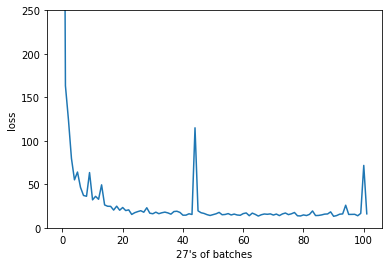

In [100]:
# visualize the loss as the network trained
plt.plot(loss_over_time)
plt.xlabel('27\'s of batches')
plt.ylabel('loss')
plt.ylim(0, 250) # consistent scale
plt.show()

## Test data

See how your model performs on previously unseen, test data. We've already loaded and transformed this data, similar to the training data. Next, run your trained model on these images to see what kind of keypoints are produced. You should be able to see if your model is fitting each new face it sees, if the points are distributed randomly, or if the points have actually overfitted the training data and do not generalize.

In [101]:
# get a sample of test data again
test_images, test_outputs, gt_pts = net_sample_output()

print(test_images.data.size())
print(test_outputs.data.size())
print(gt_pts.size())

torch.Size([8, 1, 224, 224])
torch.Size([8, 68, 2])
torch.Size([8, 68, 2])


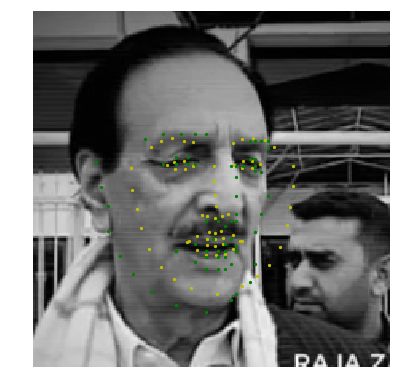

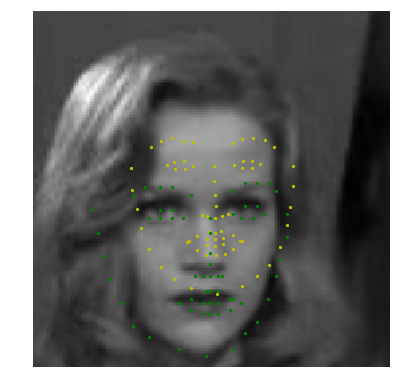

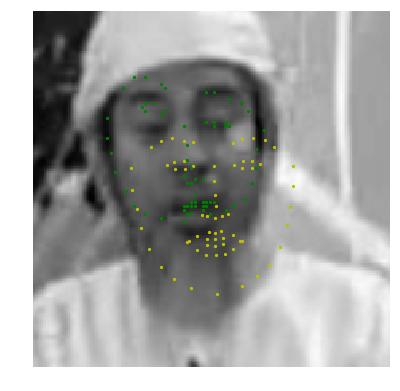

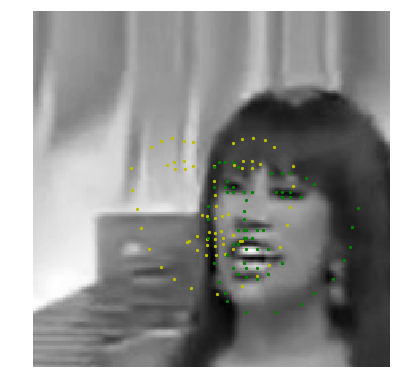

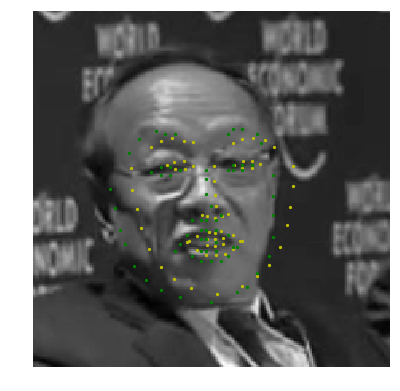

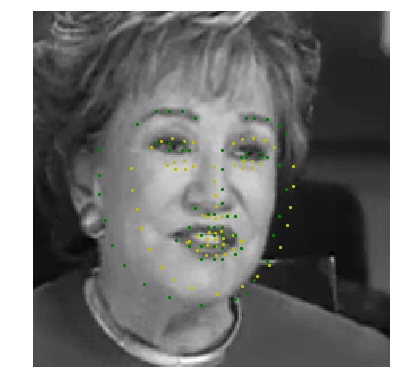

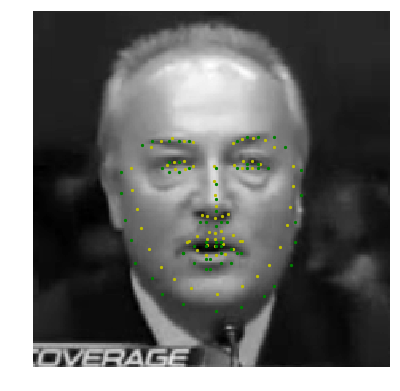

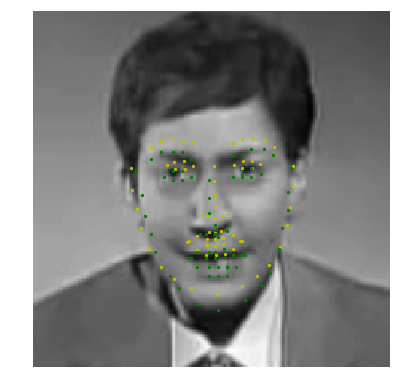

In [102]:
## TODO: visualize your test output
# you can use the same function as before, by un-commenting the line below:

visualize_output(test_images, test_outputs, batch_size, gt_pts)


Once you've found a good model (or two), save your model so you can load it and use it later!

In [41]:
## TODO: change the name to something uniqe for each new model
model_dir = 'saved_models/'
model_name = 'keypoints_model_2.pt'

# after training, save your model parameters in the dir 'saved_models'
torch.save(net.state_dict(), model_dir+model_name)

After you've trained a well-performing model, answer the following questions so that we have some insight into your training and architecture selection process. Answering all questions is required to pass this project.

### Question 1: What optimization and loss functions did you choose and why?


**Answer**: write your answer here (double click to edit this cell)

### Question 2: What kind of network architecture did you start with and how did it change as you tried different architectures? Did you decide to add more convolutional layers or any layers to avoid overfitting the data?

**Answer**: write your answer here

### Question 3: How did you decide on the number of epochs and batch_size to train your model?

**Answer**: write your answer here

## Feature Visualization

Sometimes, neural networks are thought of as a black box, given some input, they learn to produce some output. CNN's are actually learning to recognize a variety of spatial patterns and you can visualize what each convolutional layer has been trained to recognize by looking at the weights that make up each convolutional kernel and applying those one at a time to a sample image. This technique is called feature visualization and it's useful for understanding the inner workings of a CNN.

In the cell below, you can see how to extract a single filter (by index) from your first convolutional layer. The filter should appear as a grayscale grid.

[[-0.12999755 -0.03345641 -0.21452075 -0.09482409 -0.05326112]
 [-0.06171801 -0.18371809 -0.15955721 -0.11501199 -0.00862228]
 [-0.15854567 -0.15529896 -0.17144009 -0.06227745 -0.08536284]
 [-0.07054334 -0.12716338 -0.04595468 -0.11278088 -0.05903669]
 [-0.18525013 -0.00160807 -0.14184919 -0.19915801 -0.18129006]]
(5, 5)


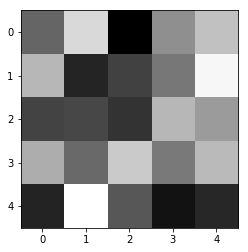

In [43]:
# Get the weights in the first conv layer, "conv1"
# if necessary, change this to reflect the name of your first conv layer
weights1 = net.conv1.weight.data

w = weights1.numpy()

filter_index = 0

print(w[filter_index][0])
print(w[filter_index][0].shape)

# display the filter weights
plt.imshow(w[filter_index][0], cmap='gray')
plt.show()

## Feature maps

Each CNN has at least one convolutional layer that is composed of stacked filters (also known as convolutional kernels). As a CNN trains, it learns what weights to include in it's convolutional kernels and when these kernels are applied to some input image, they produce a set of **feature maps**. So, feature maps are just sets of filtered images; they are the images produced by applying a convolutional kernel to an input image. These maps show us the features that the different layers of the neural network learn to extract. For example, you might imagine a convolutional kernel that detects the vertical edges of a face or another one that detects the corners of eyes. You can see what kind of features each of these kernels detects by applying them to an image. One such example is shown below; from the way it brings out the lines in an the image, you might characterize this as an edge detection filter.

<img src='images/feature_map_ex.png' width=50% height=50%/>


Next, choose a test image and filter it with one of the convolutional kernels in your trained CNN; look at the filtered output to get an idea what that particular kernel detects.

### TODO: Filter an image to see the effect of a convolutional kernel
---

In [ ]:
##TODO: load in and display any image from the transformed test dataset

## TODO: Using cv's filter2D function,
## apply a specific set of filter weights (like the one displayed above) to the test image


### Question 4: Choose one filter from your trained CNN and apply it to a test image; what purpose do you think it plays? What kind of feature do you think it detects?


**Answer**: (does it detect vertical lines or does it blur out noise, etc.) write your answer here

---
## Moving on!

Now that you've defined and trained your model (and saved the best model), you are ready to move on to the last notebook, which combines a face detector with your saved model to create a facial keypoint detection system that can predict the keypoints on *any* face in an image!